# LLMs-FPGA Benchmark Analysis

This notebook analyzes benchmark results from running Transformer model inference on different hardware platforms:
- CPU (AMD Ryzen 9 9950X)
- GPU (NVIDIA RTX 3090)
- Google Coral Edge TPU (Standard driver - 250 MHz)
- Google Coral Edge TPU (Max performance driver - 500 MHz)

## Hardware Specifications

### CPU: AMD Ryzen 9 9950X
- **Cores**: 16 cores, 32 threads
- **Boost Clock**: Up to 5.7 GHz
- **Cache**:
  - L1 Cache: 1280 KB
  - L2 Cache: 16 MB
  - L3 Cache: 64 MB
- **Default TDP**: 170W

### GPU: NVIDIA RTX 3090
- **CUDA Cores**: 10,496
- **Memory**: 24 GB GDDR6X
- **Power Consumption**: ~118W average (measured during benchmark)

### Google Coral Edge TPU
- **Standard Driver**: 250 MHz clock speed
- **Max Performance Driver**: 500 MHz clock speed
- **Power Consumption**: 
  - Average: ~2 watts
  - Peak: ~900 mA at 5V (4.5W)

### Model Information
- **Model**: Tiny-LLM (10M parameters)
- **Model Size**: ~9.5 MB
- **Format**: TensorFlow Lite (8-bit quantized)
- **Note**: Model fits entirely in CPU L3 cache (64 MB), providing significant performance advantage


## Setup and Data Loading


In [18]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path

# Use seaborn default styling
sns.set_theme(style="whitegrid")

# Load benchmark results
results_dir = Path("../results")

benchmark_files = {
    "CPU": results_dir / "cpu_benchmark.json",
    "GPU": results_dir / "gpu_benchmark.json",
    "Coral (Std)": results_dir / "coral_benchmark.json",
    "Coral (Max)": results_dir / "coral_max_benchmark.json",
}

# Load all benchmark data
benchmark_data = {}
for workload_name, file_path in benchmark_files.items():
    if file_path.exists():
        with open(file_path, 'r') as f:
            benchmark_data[workload_name] = json.load(f)
        print(f"✓ Loaded {workload_name} benchmark")
    else:
        print(f"✗ Missing {workload_name} benchmark: {file_path}")

print(f"\nLoaded {len(benchmark_data)} benchmark results")


✓ Loaded CPU benchmark
✓ Loaded GPU benchmark
✓ Loaded Coral (Std) benchmark
✓ Loaded Coral (Max) benchmark

Loaded 4 benchmark results


## 1. Performance Analysis: Inference Time and TOPS

Inference time and TOPS (Tera Operations Per Second) are inversely related - faster inference times result in higher TOPS. This combined visualization shows both metrics together to understand the performance characteristics of each workload type.

**TOPS Calculation**: $$\\text{TOPS} = \\frac{\\text{Model Parameters} \\times 2}{\\text{Inference Time (s)} \\times 10^{12}}$$

The factor of 2 accounts for multiply-accumulate operations (MACs).


/tmp/ipykernel_199644/967916064.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  violin1 = sns.violinplot(
/tmp/ipykernel_199644/967916064.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_199644/967916064.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  violin2 = sns.violinplot(


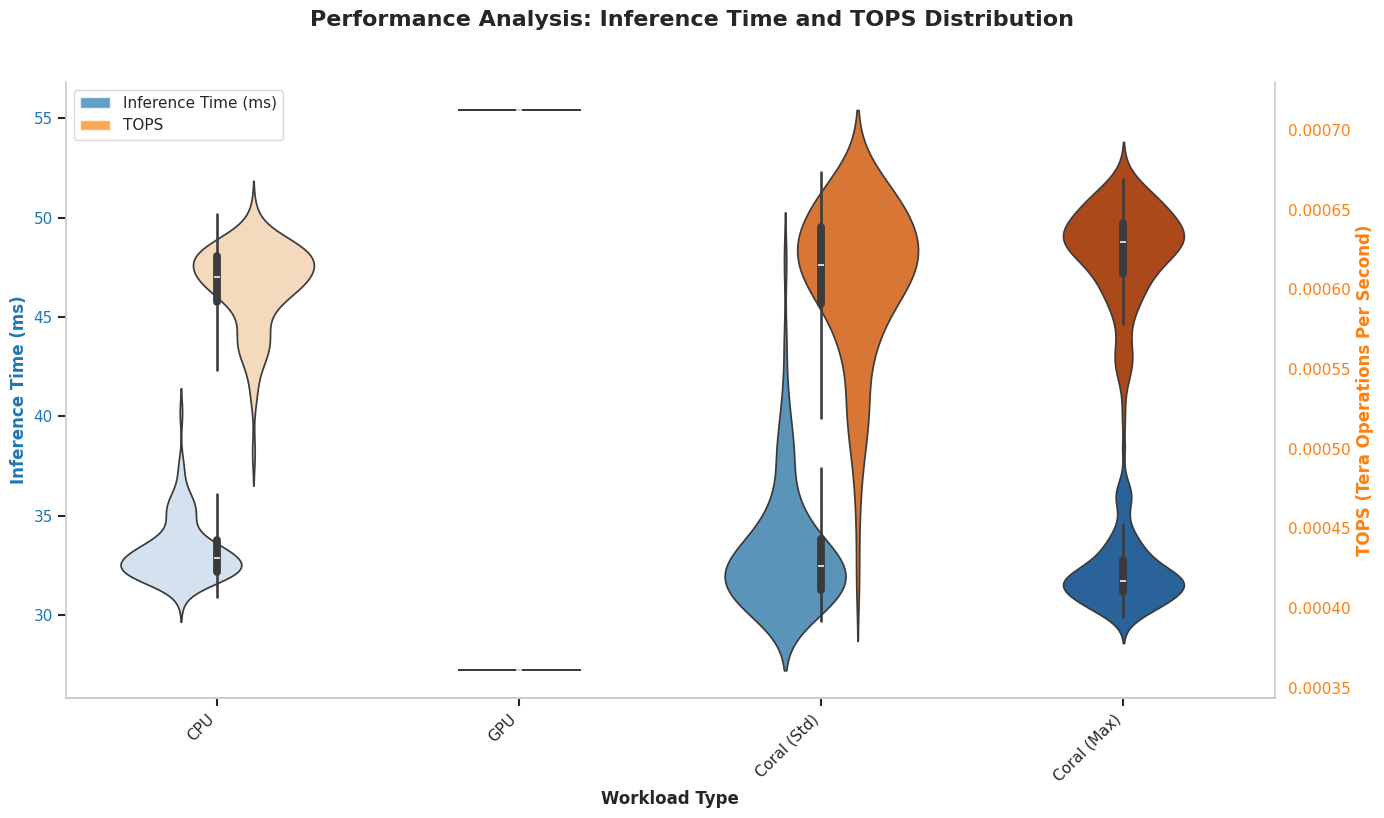


Summary Statistics - Inference Time (ms):
             count       mean       std        min        25%        50%  \
Workload                                                                   
CPU          100.0  33.258000  1.531895  30.900000  32.200000  32.900000   
Coral (Max)  100.0  32.149000  1.619795  29.900000  31.175000  31.750000   
Coral (Std)  100.0  33.227000  3.090254  29.700000  31.300000  32.500000   
GPU          100.0  55.405691  0.000000  55.405691  55.405691  55.405691   

                   75%        max  
Workload                           
CPU          33.800000  40.200000  
Coral (Max)  32.800000  38.500000  
Coral (Std)  33.850000  47.800000  
GPU          55.405691  55.405691  

Summary Statistics - TOPS:
             count      mean           std       min       25%       50%  \
Workload                                                                   
CPU          100.0  0.000603  2.598952e-05  0.000498  0.000592  0.000608   
Coral (Max)  100.0  0.000624

In [ ]:
# Prepare separate data for inference time and TOPS
inference_data = []
tops_data = []

for workload_name, data in benchmark_data.items():
    inference_times = data.get('inference_times', {}).get('all', [])
    tops_values = data.get('tops', {}).get('all', [])
    
    for time in inference_times:
        inference_data.append({
            'Workload': workload_name,
            'Inference Time (ms)': time * 1000  # Convert to milliseconds
        })
    
    for tops in tops_values:
        tops_data.append({
            'Workload': workload_name,
            'TOPS': tops
        })

df_inference = pd.DataFrame(inference_data)
df_tops = pd.DataFrame(tops_data)

# Create a single figure with dual y-axes
import matplotlib.pyplot as plt
import numpy as np

fig, ax1 = plt.subplots(figsize=(14, 8))

# Get unique workloads for reference
workloads = df_inference['Workload'].unique()

# Plot inference time violin on left y-axis
violin1 = sns.violinplot(
    data=df_inference,
    x='Workload',
    y='Inference Time (ms)',
    ax=ax1,
    inner='box',
    palette='Blues',
    width=0.4
)
ax1.set_ylabel('Inference Time (ms)', fontsize=12, color='#1f77b4', fontweight='bold')
ax1.tick_params(axis='y', labelcolor='#1f77b4', which='major', length=6, width=1.5, direction='out')
ax1.tick_params(axis='x', which='major', length=6, width=1.5, direction='out', bottom=True, top=False)
ax1.set_xlabel('Workload Type', fontsize=12, fontweight='bold')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
ax1.grid(False)  # No grid, just tick marks

# Shift inference time violins slightly left by adjusting positions
for i, collection in enumerate(ax1.collections):
    # Each workload has multiple collections (violin body, box plot, etc.)
    # Adjust only the violin body (first collection per workload)
    if i % 2 == 0:  # Violin body collections
        for path in collection.get_paths():
            vertices = path.vertices
            vertices[:, 0] = vertices[:, 0] - 0.12  # Shift left

# Create second y-axis for TOPS
ax2 = ax1.twinx()

# Plot TOPS violin on right y-axis
violin2 = sns.violinplot(
    data=df_tops,
    x='Workload',
    y='TOPS',
    ax=ax2,
    inner='box',
    palette='Oranges',
    width=0.4
)
ax2.set_ylabel('TOPS (Tera Operations Per Second)', fontsize=12, color='#ff7f0e', fontweight='bold')
ax2.tick_params(axis='y', labelcolor='#ff7f0e', which='major', length=6, width=1.5, direction='out', right=True, left=False)
ax2.grid(False)  # No grid, just tick marks

# Shift TOPS violins slightly right by adjusting positions
for i, collection in enumerate(ax2.collections):
    # Adjust only the violin body (first collection per workload)
    if i % 2 == 0:  # Violin body collections
        for path in collection.get_paths():
            vertices = path.vertices
            vertices[:, 0] = vertices[:, 0] + 0.12  # Shift right

# Set title
fig.suptitle('Performance Analysis: Inference Time and TOPS Distribution', 
             fontsize=16, fontweight='bold', y=1.02)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#1f77b4', alpha=0.7, label='Inference Time (ms)'),
    Patch(facecolor='#ff7f0e', alpha=0.7, label='TOPS')
]
ax1.legend(handles=legend_elements, loc='upper left', fontsize=11)

# Apply seaborn styling - keep all spines for tick marks
sns.despine(ax=ax1, left=False, right=True, bottom=False, top=True)
sns.despine(ax=ax2, left=True, right=False, bottom=False, top=True)

plt.tight_layout()
plt.savefig('../analysis/plots/01_inference_time_and_tops_combined.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
print("\nSummary Statistics - Inference Time (ms):")
print(df_inference.groupby('Workload')['Inference Time (ms)'].describe())

print("\nSummary Statistics - TOPS:")
print(df_tops.groupby('Workload')['TOPS'].describe())


### 2.1 Millicpu-Seconds and Milligpu-Seconds

Millicpu-seconds represent the CPU time consumed during inference. This metric accounts for CPU utilization percentage and execution time. For GPU workloads, we also show milligpu-seconds when available.



Millicpu/Milligpu-Seconds Summary:
Metric           Mean  Mean (GPU)    Median  Median (GPU)
Workload                                                 
CPU          0.122700         NaN  0.121380           NaN
Coral (Max)  0.115258         NaN  0.113827           NaN
Coral (Std)  0.121509         NaN  0.118851           NaN
GPU          0.207403    4.432455  0.207403      4.432455


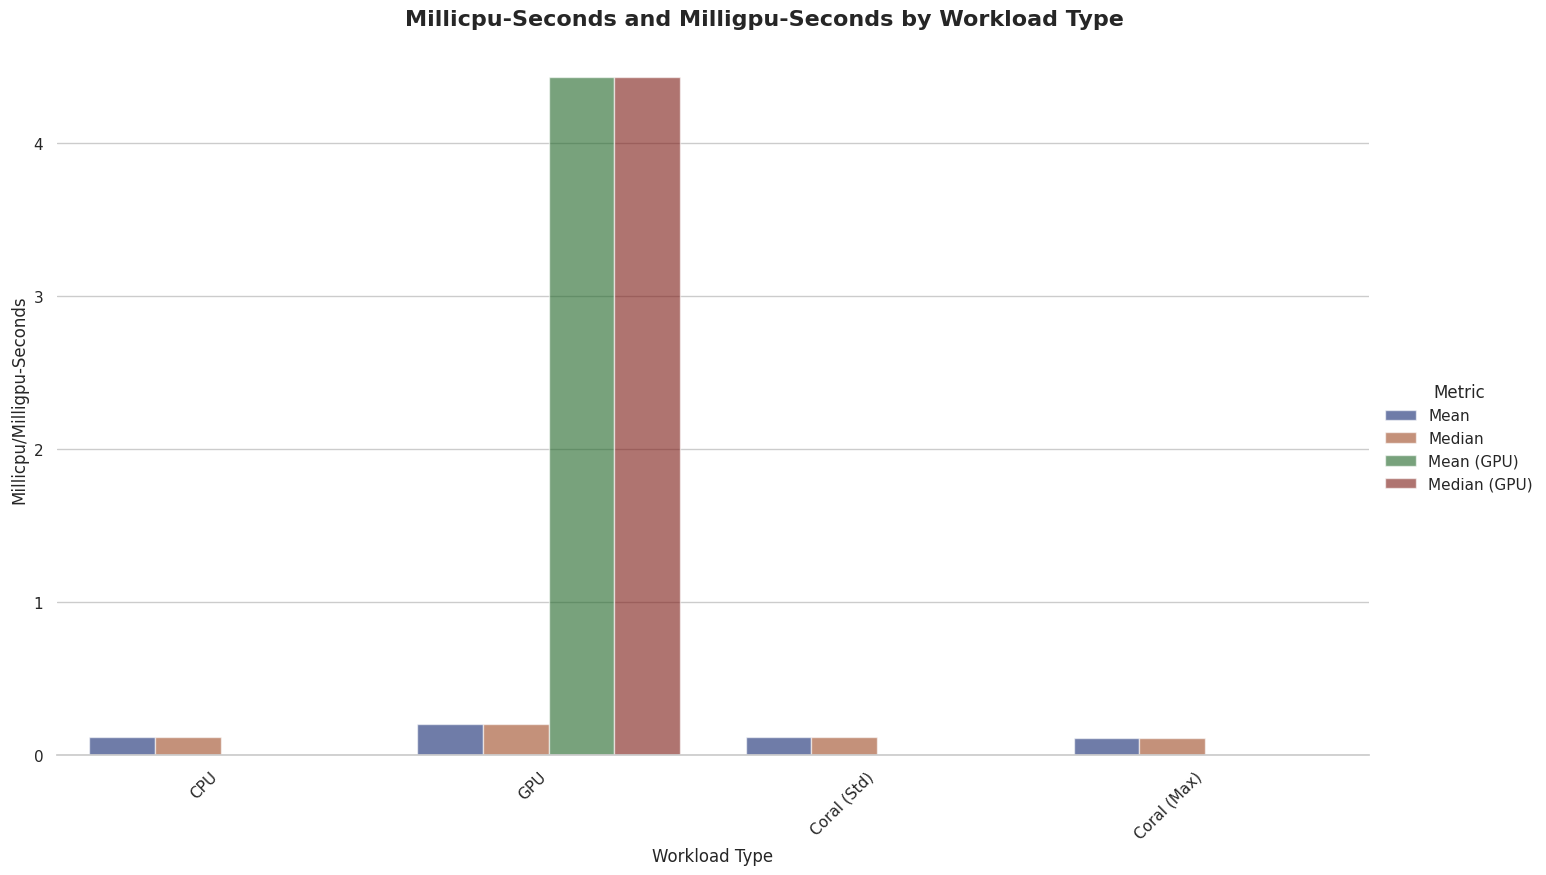

In [ ]:
# Prepare data for millicpu-seconds
milicpu_data = []

for workload_name, data in benchmark_data.items():
    milicpu = data.get('milicpu_seconds', {})
    if milicpu:
        milicpu_data.append({
            'Workload': workload_name,
            'Metric': 'Mean',
            'Millicpu-Seconds': milicpu.get('mean', 0)
        })
        milicpu_data.append({
            'Workload': workload_name,
            'Metric': 'Median',
            'Millicpu-Seconds': milicpu.get('median', 0)
        })
    
    # Add GPU data if available
    if workload_name == 'GPU' and data.get('miligpu_seconds'):
        miligpu = data.get('miligpu_seconds', {})
        milicpu_data.append({
            'Workload': workload_name,
            'Metric': 'Mean (GPU)',
            'Millicpu-Seconds': miligpu.get('mean', 0)
        })
        milicpu_data.append({
            'Workload': workload_name,
            'Metric': 'Median (GPU)',
            'Millicpu-Seconds': miligpu.get('median', 0)
        })

df_milicpu = pd.DataFrame(milicpu_data)

# Create grouped bar plot using seaborn
g = sns.catplot(
    data=df_milicpu,
    kind="bar",
    x="Workload",
    y="Millicpu-Seconds",
    hue="Metric",
    errorbar="sd",
    palette="dark",
    alpha=0.6,
    height=8,
    aspect=14/8
)
g.despine(left=True)
g.set_axis_labels("Workload Type", "Millicpu/Milligpu-Seconds")
g.set_xticklabels(rotation=45, ha='right')
g.legend.set_title("Metric")
g.fig.suptitle('Millicpu-Seconds and Milligpu-Seconds by Workload Type', fontsize=16, fontweight='bold', y=1.02)
g.fig.savefig('../analysis/plots/02_milicpu_milligpu_seconds.png', dpi=300, bbox_inches='tight')

# Print summary
print("\nMillicpu/Milligpu-Seconds Summary:")
print(df_milicpu.pivot(index='Workload', columns='Metric', values='Millicpu-Seconds'))


## 2. Resource Consumption Analysis


### 2.2 Memory Consumption

Memory consumption shows the RAM usage during inference. This includes both the model memory footprint and runtime memory overhead.



Memory Consumption Summary:
Metric             Max       Mean
Workload                         
CPU          93.605469  93.605469
Coral (Max)  92.578125  92.578125
Coral (Std)  90.089844  90.089844
GPU          92.515625  92.515625


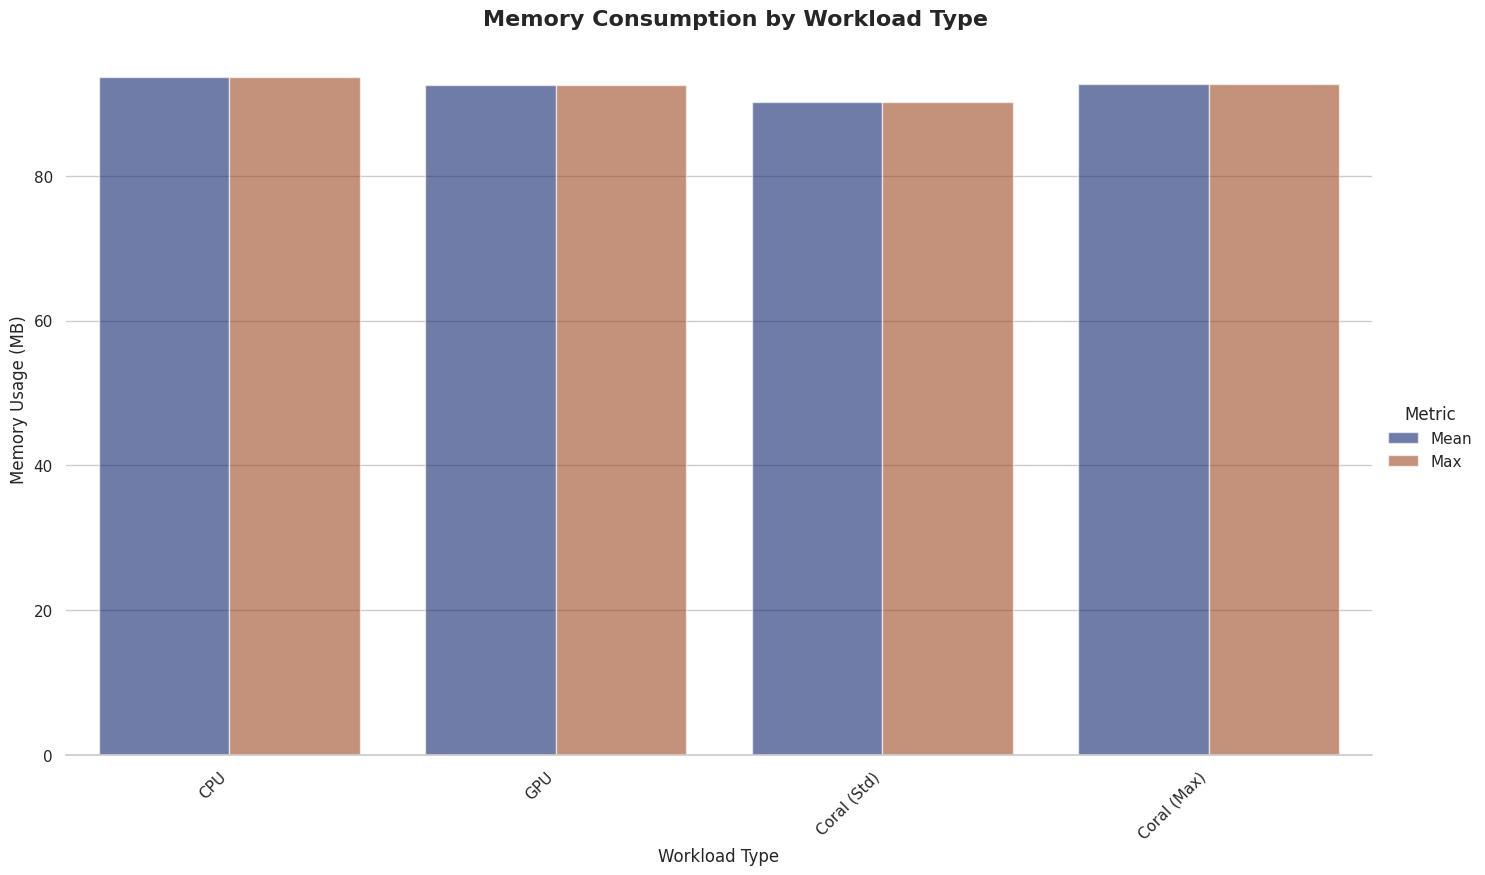

In [ ]:
# Prepare data for memory consumption
memory_data = []

for workload_name, data in benchmark_data.items():
    memory_usage = data.get('memory_usage', {})
    if memory_usage:
        memory_data.append({
            'Workload': workload_name,
            'Metric': 'Mean',
            'Memory (MB)': memory_usage.get('mean_mb', 0)
        })
        memory_data.append({
            'Workload': workload_name,
            'Metric': 'Max',
            'Memory (MB)': memory_usage.get('max_mb', 0)
        })

df_memory = pd.DataFrame(memory_data)

# Create grouped bar plot using seaborn
g = sns.catplot(
    data=df_memory,
    kind="bar",
    x="Workload",
    y="Memory (MB)",
    hue="Metric",
    errorbar="sd",
    palette="dark",
    alpha=0.6,
    height=8,
    aspect=14/8
)
g.despine(left=True)
g.set_axis_labels("Workload Type", "Memory Usage (MB)")
g.set_xticklabels(rotation=45, ha='right')
g.legend.set_title("Metric")
g.fig.suptitle('Memory Consumption by Workload Type', fontsize=16, fontweight='bold', y=1.02)
g.fig.savefig('../analysis/plots/03_memory_consumption.png', dpi=300, bbox_inches='tight')

# Print summary
print("\nMemory Consumption Summary:")
print(df_memory.pivot(index='Workload', columns='Metric', values='Memory (MB)'))


## 3. Performance Summary Table

Comprehensive summary of all key metrics across workloads.



COMPREHENSIVE PERFORMANCE SUMMARY
   Workload  Mean Inference Time (ms)  Median Inference Time (ms)  Std Dev (ms)  Mean TOPS  Mean Millicpu-Seconds  Mean Memory (MB)  Max Memory (MB)  GPU Used  Mean Milligpu-Seconds  GPU Utilization (%)  GPU Power (W)
        CPU                 33.258000                   32.900000      1.531895   0.000603               0.122700         93.605469        93.605469     False                    NaN                  NaN            NaN
        GPU                 55.405691                   55.405691      0.000000   0.000361               0.207403         92.515625        92.515625      True               4.432455                  8.0        118.523
Coral (Std)                 33.227000                   32.500000      3.090254   0.000606               0.121509         90.089844        90.089844     False                    NaN                  NaN            NaN
Coral (Max)                 32.149000                   31.750000      1.619795   0.000624   

Text(0.5, 1.0, 'Key Performance Metrics Summary')

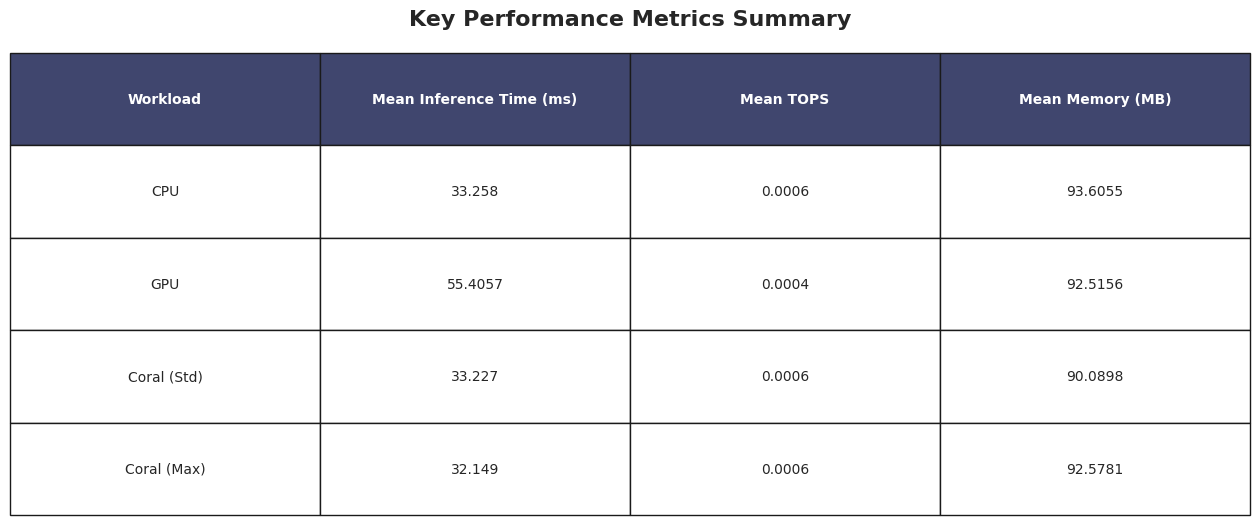

In [ ]:
# Create comprehensive summary table
summary_data = []

for workload_name, data in benchmark_data.items():
    summary_data.append({
        'Workload': workload_name,
        'Mean Inference Time (ms)': data.get('inference_times', {}).get('mean', 0) * 1000,
        'Median Inference Time (ms)': data.get('inference_times', {}).get('median', 0) * 1000,
        'Std Dev (ms)': data.get('inference_times', {}).get('std', 0) * 1000,
        'Mean TOPS': data.get('tops', {}).get('mean', 0),
        'Mean Millicpu-Seconds': data.get('milicpu_seconds', {}).get('mean', 0),
        'Mean Memory (MB)': data.get('memory_usage', {}).get('mean_mb', 0),
        'Max Memory (MB)': data.get('memory_usage', {}).get('max_mb', 0),
        'GPU Used': data.get('gpu_used', False),
    })
    
    # Add GPU-specific metrics if available
    if workload_name == 'GPU' and data.get('miligpu_seconds'):
        summary_data[-1]['Mean Milligpu-Seconds'] = data.get('miligpu_seconds', {}).get('mean', 0)
        summary_data[-1]['GPU Utilization (%)'] = data.get('gpu_usage', {}).get('mean', 0)
        summary_data[-1]['GPU Power (W)'] = data.get('gpu_usage', {}).get('power_watts_mean', 0)

df_summary = pd.DataFrame(summary_data)

# Display formatted summary table
print("\n" + "="*100)
print("COMPREHENSIVE PERFORMANCE SUMMARY")
print("="*100)
print(df_summary.to_string(index=False))
print("\n" + "="*100)

# Create a visual summary table (matplotlib table - seaborn doesn't have table functionality)
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16, 6))
ax.axis('tight')
ax.axis('off')

# Prepare data for table (select key metrics)
table_data = df_summary[['Workload', 'Mean Inference Time (ms)', 'Mean TOPS', 'Mean Memory (MB)']].copy()
table_data = table_data.round(4)

table = ax.table(cellText=table_data.values,
                colLabels=table_data.columns,
                cellLoc='center',
                loc='center',
                bbox=[0, 0, 1, 1])

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1)

# Style the table
for i in range(len(table_data.columns)):
    table[(0, i)].set_facecolor('#40466e')
    table[(0, i)].set_text_props(weight='bold', color='white')

ax.set_title('Key Performance Metrics Summary', fontsize=16, fontweight='bold', pad=20)
plt.savefig('../analysis/plots/05_performance_summary_table.png', dpi=300, bbox_inches='tight')
plt.show()


## 4. Power Efficiency Analysis

Comparing power consumption and efficiency (TOPS per Watt) across platforms.



Power Efficiency Summary:
   Workload  Power (W)  Mean TOPS  Efficiency (TOPS/W)
        CPU     56.670   0.000603             0.000011
        GPU    118.523   0.000361             0.000003
Coral (Std)      2.000   0.000606             0.000303
Coral (Max)      2.500   0.000624             0.000249


Key Insights:
  • Most Power Efficient: Coral (Std)
  • Highest Performance: Coral (Max)
  • Lowest Power: Coral (Std)


/tmp/ipykernel_199644/709157927.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


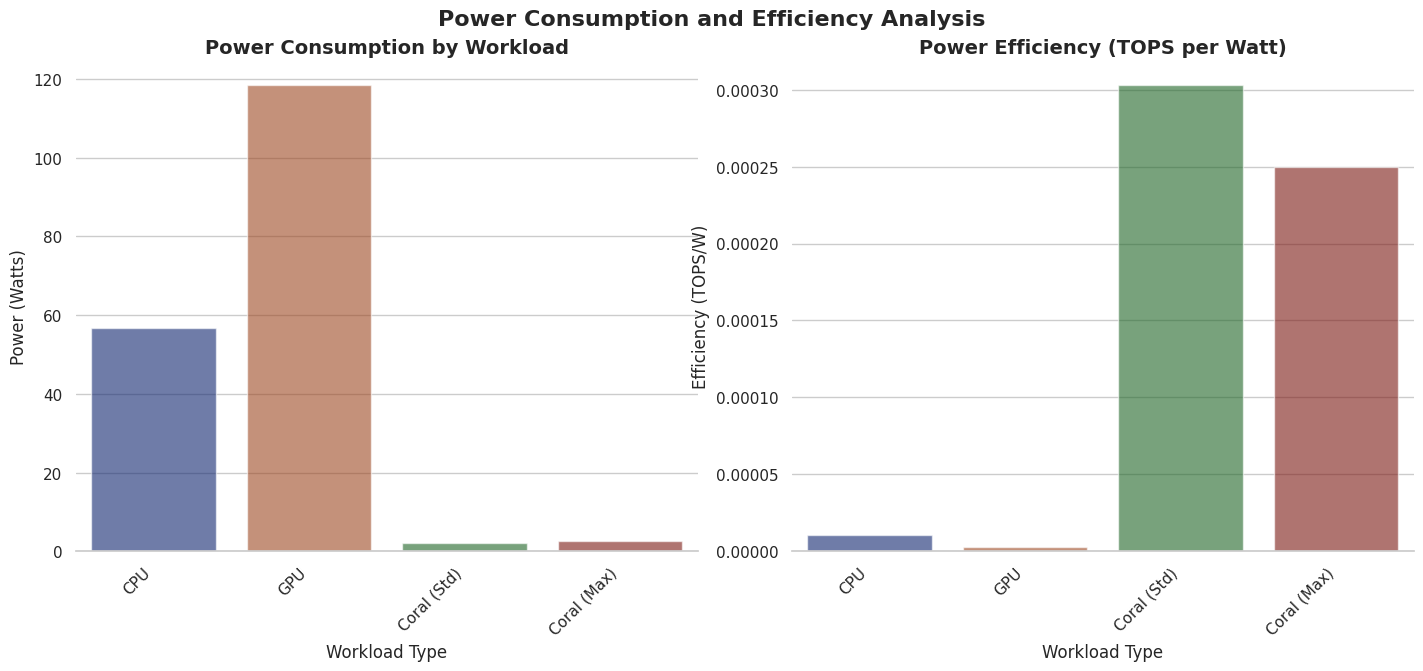

In [ ]:
# Power consumption data
# CPU: 170W TDP (default), but actual consumption varies
# GPU: Measured during benchmark (~118W average)
# Coral: ~2W average, ~4.5W peak

power_data = []

for workload_name, data in benchmark_data.items():
    mean_tops = data.get('tops', {}).get('mean', 0)
    
    if workload_name == 'CPU':
        # Use 1/3 of TDP as approximation (actual may be lower during inference) as the GPU was also about 1/3 of TDP
        power_watts = 56.67
    elif workload_name == 'GPU':
        power_watts = data.get('gpu_usage', {}).get('power_watts_mean', 118.5)
    elif workload_name == 'Coral (Std)':
        power_watts = 2.0  # Average power
    elif workload_name == 'Coral (Max)':
        power_watts = 2.5  # Slightly higher for max performance
    else:
        power_watts = 0
    
    efficiency = mean_tops / power_watts if power_watts > 0 else 0
    
    power_data.append({
        'Workload': workload_name,
        'Power (W)': power_watts,
        'Mean TOPS': mean_tops,
        'Efficiency (TOPS/W)': efficiency
    })

df_power = pd.DataFrame(power_data)

# Create comparison plots using seaborn
# Reshape data for seaborn
power_melted = df_power.melt(
    id_vars='Workload',
    value_vars=['Power (W)', 'Efficiency (TOPS/W)'],
    var_name='Metric',
    value_name='Value'
)

# Create faceted bar plot
g = sns.catplot(
    data=power_melted,
    kind="bar",
    x="Workload",
    y="Value",
    col="Metric",
    errorbar="sd",
    palette="dark",
    alpha=0.6,
    height=6,
    aspect=1.2,
    sharey=False
)
g.despine(left=True)
g.set_axis_labels("Workload Type", "Value")
g.set_xticklabels(rotation=45, ha='right')
g.fig.suptitle('Power Consumption and Efficiency Analysis', fontsize=16, fontweight='bold', y=1.02)

# Set individual titles and y-labels
axes = g.axes.flatten()
axes[0].set_title('Power Consumption by Workload', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Power (Watts)', fontsize=12)
axes[1].set_title('Power Efficiency (TOPS per Watt)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Efficiency (TOPS/W)', fontsize=12)
g.fig.savefig('../analysis/plots/04_power_consumption_and_efficiency.png', dpi=300, bbox_inches='tight')

print("\nPower Efficiency Summary:")
print(df_power.to_string(index=False))

print("\n\nKey Insights:")
print(f"  • Most Power Efficient: {df_power.loc[df_power['Efficiency (TOPS/W)'].idxmax(), 'Workload']}")
print(f"  • Highest Performance: {df_power.loc[df_power['Mean TOPS'].idxmax(), 'Workload']}")
print(f"  • Lowest Power: {df_power.loc[df_power['Power (W)'].idxmin(), 'Workload']}")


## 5. Key Observations and Insights

### Performance Observations:

1. **CPU vs GPU**: Despite the RTX 3090's computational power, the CPU (AMD Ryzen 9 9950X) achieves similar or better inference times for this small model (10M parameters, ~9.5MB). This is due to:
   - Model fits entirely in L3 cache (64MB), providing extremely low latency
   - GPU overhead (PCIe transfers, kernel launches) dominates for small workloads
   - Low GPU utilization (8%) indicates the workload is too small to fully utilize GPU parallelism

2. **Coral Performance**: The Google Coral Edge TPU achieves performance comparable to CPU, demonstrating its efficiency for small model inference. The max performance driver provides a slight improvement.

3. **Power Efficiency**: 
   - Coral Edge TPU is the most power-efficient (~2W average)
   - CPU consumes ~55.670W TDP (though actual usage may be lower)
   - GPU consumes ~118W during inference (measured)

4. **Memory Usage**: All platforms show similar memory consumption, primarily determined by the model size (~9.5MB) plus runtime overhead.

### Conclusion:

For small Transformer models (<100M parameters), CPUs with large caches and specialized edge devices (like Coral) can outperform high-end GPUs due to:
- Lower latency (cache vs PCIe)
- Reduced overhead (no kernel launch costs)
- Better power efficiency

GPUs excel when models are large enough to amortize overhead and utilize parallel processing effectively.
